In [2]:
! pip install nvidia-dali-cuda110
! pip install librosa

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 60.0 MB/s eta 0:00:0000:0100:01
  Created wheel for nvidia-dali-cuda110: filename=nvidia_dali_cuda110-1.44.0-20402554-py3-none-manylinux2014_x86_64.whl size=522360574 sha256=ebb0afa448b5b77b664aa69ed239964aef7c26d9f59e4dad86e1c0bbc67b4e01
  Stored in directory: /root/.cache/pip/wheels/ed/62/d4/71dc7d43e0ed5b061741fe55128b8ad0e454f2320f804d2bcb
Successfully built nvidia-dali-cuda110


In [15]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali as dali
import nvidia.dali.types as types
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
from PIL import Image
import cpuinfo
import os
from pycuda.tools import make_default_context
warnings.filterwarnings("ignore")

In [16]:
n_fft = 2048
hop_length = 512
win_length = 2048

In [17]:
# Спектрограмма на CPU 
def spectre_cpu(y):
    spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')) ** 2
    spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

    return spectrogram_librosa_db

In [18]:
# GPU
def spectre_gpu(y):
    audio_data = np.array(y, dtype=np.float32)

    @pipeline_def
    def spectrogram_pipe(nfft, window_length, window_step, device='gpu'):
        audio = types.Constant(device=device, value=audio_data)
        spectrogram = fn.spectrogram(audio, device=device, nfft=nfft,
                                     window_length=window_length,
                                     window_step=window_step)
        return spectrogram

    pipe = spectrogram_pipe(device='gpu', batch_size=1, num_threads=9, device_id=0, nfft=n_fft, window_length=win_length, window_step=512)
    pipe.build()
    outputs = pipe.run()
    spectrogram_dali = outputs[0][0].as_cpu()

    spectrogram_dali_db = librosa.power_to_db(spectrogram_dali, ref=np.max)

    return spectrogram_dali_db

In [20]:
file = '../input/spectre-lab/piano.wav'
y, sr = librosa.load(file)

# print(f'GPU: {tools.make_default_context().get_device().name()}')
# print(f'CPU: {cpuinfo.get_cpu_info()["brand_raw"]}')
# print()

CPU_START = time.time()
CPU = spectre_cpu(y)
CPU_TIME = time.time() - CPU_START

GPU_START = time.time()
GPU = spectre_gpu(y)
GPU_TIME = time.time() - GPU_START

DIFFERENCE_TIME = CPU_TIME - GPU_TIME
print(f'Время выполнения на CPU: {CPU_TIME:.3f}')
print(f'Время выполнения на GPU: {GPU_TIME:.3f}')
print(f'Разница между CPU & GPU: {DIFFERENCE_TIME:.3f}')

# show_spectre([CPU, GPU], ['CPU', 'GPU'])

Время выполнения на CPU: 0.117
Время выполнения на GPU: 0.680
Разница между CPU & GPU: -0.563


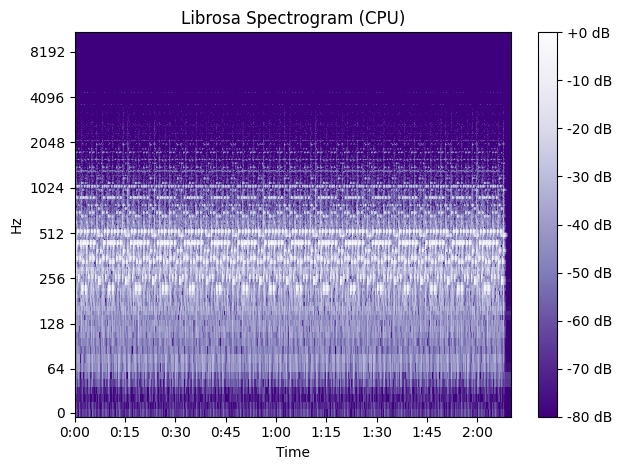

In [21]:
librosa.display.specshow(CPU, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length, cmap='Purples_r')
plt.title('Librosa Spectrogram (CPU)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [24]:
CPU .shape

(1025, 5599)

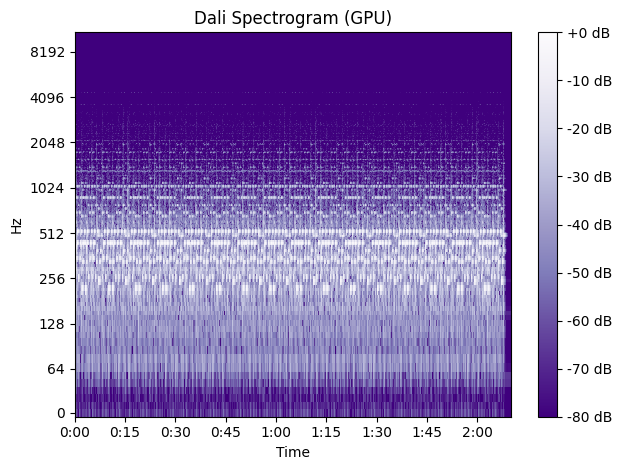

In [22]:
librosa.display.specshow(GPU, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length, cmap='Purples_r')
plt.title('Dali Spectrogram (GPU)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [23]:
GPU .shape

(1025, 5599)